# Deep Q-Learning - Aterrizaje lunar

En esta tarea, usted entrenará a un agente para que aterrice un módulo de aterrizaje lunar de forma segura en una plataforma de aterrizaje en la superficie de la luna.


# Outline
- [ 1 - Import Packages <img align="Right" src="./images/lunar_lander.gif" width = 60% >](#1)
- [ 2 - Hyperparameters](#2)
- [ 3 - The Lunar Lander Environment](#3)
  - [ 3.1 Action Space](#3.1)
  - [ 3.2 Observation Space](#3.2)
  - [ 3.3 Rewards](#3.3)
  - [ 3.4 Episode Termination](#3.4)
- [ 4 - Load the Environment](#4)
- [ 5 - Interacting with the Gym Environment](#5)
    - [ 5.1 Exploring the Environment's Dynamics](#5.1)
- [ 6 - Deep Q-Learning](#6)
  - [ 6.1 Target Network](#6.1)
    - [ Exercise 1](#ex01)
  - [ 6.2 Experience Replay](#6.2)
- [ 7 - Deep Q-Learning Algorithm with Experience Replay](#7)
  - [ Exercise 2](#ex02)
- [ 8 - Update the Network Weights](#8)
- [ 9 - Train the Agent](#9)
- [ 10 - See the Trained Agent In Action](#10)
- [ 11 - Congratulations!](#11)
- [ 12 - References](#12)


<a name="1"></a>
## 1 - Paquetes de importación

Haremos uso de los siguientes paquetes:
- `numpy` es un paquete para la computación científica en python.
- `deque` será nuestra estructura de datos para nuestro buffer de memoria.
- `namedtuple` se utilizará para almacenar las tuplas de experiencia.
- El conjunto de herramientas `gym` es una colección de entornos que pueden utilizarse para probar algoritmos de aprendizaje por refuerzo. Debemos tener en cuenta que en este cuaderno estamos utilizando la versión `gym` `0.24.0`.
- Los módulos `PIL.Image` y `pyvirtualdisplay` son necesarios para renderizar el entorno del Lunar Lander.
- Utilizaremos varios módulos del framework `tensorflow.keras` para construir modelos de aprendizaje profundo.
- `utils` es un módulo que contiene funciones de ayuda para esta tarea. No es necesario modificar el código de este archivo.

Ejecuta la celda de abajo para importar todos los paquetes necesarios.

In [1]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [2]:
# Configure una pantalla virtual para renderizar el entorno del Lunar Lander.
Display(visible=0, size=(840, 480)).start();

# Establece la semilla aleatoria para TensorFlow.
tf.random.set_seed(utils.SEED)

<a name="2"></a>
## 2 - Hiperparámetros

Ejecute la celda siguiente para establecer los hiperparámetros.

In [19]:
MEMORY_SIZE           = 100_000 # tamaño del buffer de memoria.
GAMMA                = 0.995   # factor de descuento.
ALPHA                = 1e-3    # tasa de aprendizaje.
NUM_STEPS_FOR_UPDATE = 4       # realizar una actualización de aprendizaje cada C pasos de tiempo.

<a name="3"></a>
## 3 - The Lunar Lander Environment

IEn este cuaderno utilizaremos [OpenAI's Gym Library](https://www.gymlibrary.dev/). La librería Gym proporciona una gran variedad de entornos para el aprendizaje por refuerzo. En pocas palabras, un entorno representa un problema o tarea a resolver. En este cuaderno, intentaremos resolver el entorno del Lunar Lander utilizando el aprendizaje por refuerzo.

El objetivo del entorno del Lunar Lander es aterrizar el módulo de aterrizaje lunar de forma segura en la plataforma de aterrizaje en la superficie de la luna. La plataforma de aterrizaje está designada por dos postes de bandera y siempre está en las coordenadas `(0,0)` pero el módulo de aterrizaje también puede aterrizar fuera de la plataforma de aterrizaje. El módulo de aterrizaje comienza en el centro superior del entorno con una fuerza inicial aleatoria aplicada a su centro de masa y tiene combustible infinito. El entorno se considera resuelto si obtiene `200` puntos. 

<br>
<br>
<figure>
  <img src = "images/lunar_lander.gif" width = 40%>
      <figcaption style = "text-align: center; font-style: italic">Fig 1. Lunar Lander Environment.</figcaption>
</figure>



<a name="3.1"></a>
### 3.1 Espacio de acción

El agente tiene cuatro acciones discretas disponibles:

* No hacer nada.
* Disparar el motor derecho.
* Disparar el motor principal.
* Disparar el motor izquierdo.

Cada acción tiene un valor numérico correspondiente:

```python
Do_nothing = 0
Fire_right_engine = 1
Fire_main_engine = 2
Fire_left_engine = 3
```

<a name="3.2"></a>
### 3.2 Espacio de observación

El espacio de observación del agente consiste en un vector de estado con 8 variables:

* Sus coordenadas $(x,y)$. La plataforma de aterrizaje está siempre en las coordenadas $(0,0)$.
* Sus velocidades lineales $(\dot x,\dot y)$.
* Su ángulo $\theta$.
* Su velocidad angular $\dot \theta$.
* Dos booleanos, $l$ y $r$, que representan si cada pata está en contacto con el suelo o no.

<a name="3.3"></a>
### 3.3 Recompensas

El entorno del Lunar Lander tiene el siguiente sistema de recompensas:

* Aterrizar en la plataforma de aterrizaje y llegar a descansar supone unos 100-140 puntos.
* Si el módulo de aterrizaje se aleja de la plataforma de aterrizaje, pierde la recompensa. 
* Si el módulo de aterrizaje se estrella, recibe -100 puntos.
* Si el módulo de aterrizaje se detiene, recibe +100 puntos.
* Cada tramo con contacto con el suelo es +10 puntos.
* Disparar el motor principal es -0.3 puntos en cada cuadro.
* Disparar el motor lateral es -0.03 puntos en cada cuadro.

<a name="3.4"></a>
### 3.4 Finalización del episodio

Un episodio termina (es decir, el entorno entra en un estado terminal) si:

* El módulo de aterrizaje lunar se estrella (es decir, si el cuerpo del módulo de aterrizaje lunar entra en contacto con la superficie de la luna).

* El valor absoluto de la coordenada $x$ del módulo de aterrizaje es mayor que 1 (es decir, va más allá del borde izquierdo o derecho).

Puedes consultar la [documentación de Open AI Gym](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) para una descripción completa del entorno. 

<a name="4"></a>
## 4 - Cargar el entorno

Comenzamos cargando el entorno `LunarLander-v2` de la biblioteca `gym` utilizando el método `.make()`. `LunarLander-v2` es la última versión del entorno de Lunar Lander y puedes leer su historial de versiones en la [documentación de Open AI Gym](https://www.gymlibrary.dev/environments/box2d/lunar_lander/#version-history).

In [4]:
env = gym.make('LunarLander-v2')

Una vez que cargamos el entorno utilizamos el método `.reset()` para restablecer el entorno al estado inicial. El módulo de aterrizaje comienza en el centro superior del entorno y podemos renderizar el primer fotograma del entorno utilizando el método `.render()`.

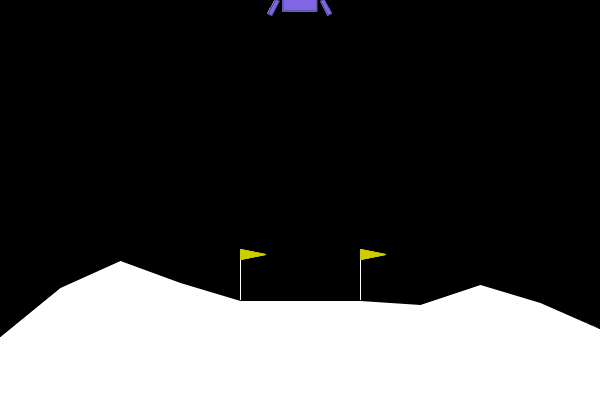

In [5]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

Para construir posteriormente nuestra red neuronal necesitamos conocer el tamaño del vector de estados y el número de acciones válidas. Podemos obtener esta información de nuestro entorno utilizando los métodos `.observation_space.shape` y `action_space.n`, respectivamente.

In [6]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


<a name="5"></a>
## 5 - Interacción con el entorno Gym

La biblioteca Gym implementa el formalismo estándar de "bucle agente-entorno":

<br>
<center>
<video src = "./videos/rl_formalism.m4v" width="840" height="480" controls autoplay loop poster="./images/rl_formalism.png"> </video>
<figcaption style = "text-align:center; font-style:italic">Fig 2. Agent-environment Loop Formalism.</figcaption>
</center>
<br>

En el formalismo estándar de "bucle agente-entorno", un agente interactúa con el entorno en pasos de tiempo discretos $t=0,1,2,...$. En cada paso de tiempo $t$, el agente utiliza una política $\pi$ para seleccionar una acción $A_t$ basada en su observación del estado del entorno $S_t$. El agente recibe una recompensa numérica $R_t$ y en el siguiente paso de tiempo, se mueve a un nuevo estado $S_{t+1}$.

<a name="5.1"></a>
### 5.1 Exploración de la dinámica del entorno

En los entornos Gym de Open AI, utilizamos el método `.step()` para ejecutar un único paso de tiempo de la dinámica del entorno. En la versión de `gym` que estamos utilizando el método `.step()` acepta una acción y devuelve cuatro valores:

* `observation` (**objeto**): un objeto específico del entorno que representa su observación del entorno. En el entorno del Lunar Lander esto corresponde a una matriz numpy que contiene las posiciones y velocidades del módulo de aterrizaje como se describe en la sección [3.2 Espacio de Observación](#3.2).


* `reward` (**float**): cantidad de recompensa devuelta como resultado de realizar la acción dada. En el entorno de Lunar Lander se corresponde con un float de tipo `numpy.float64` como se describe en la sección [3.3 Recompensas](#3.3).


* `done` (**booleano**): Cuando done es `True`, indica que el episodio ha terminado y es hora de reiniciar el entorno. 


* `info` (**diccionario**): información de diagnóstico útil para la depuración. No usaremos esta variable en este cuaderno pero se muestra aquí para completarla.

Para comenzar un episodio, necesitamos restablecer el entorno a un estado inicial. Esto lo hacemos utilizando el método `.reset()`. 

In [7]:
# Reiniciar el entorno y obtener el estado inicial.
initial_state = env.reset()

Una vez reiniciado el entorno, el agente puede empezar a realizar acciones en el entorno utilizando el método `.step()`. Ten en cuenta que el agente sólo puede realizar una acción por paso de tiempo. 

En la celda de abajo puedes seleccionar diferentes acciones y ver cómo cambian los valores devueltos en función de la acción realizada. Recuerda que en este entorno el agente tiene cuatro acciones discretas disponibles y las especificamos en código utilizando su correspondiente valor numérico:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

In [9]:
# Seleccione una acción.
action = 0

# Ejecuta un único paso de tiempo de la dinámica del entorno con la acción dada.
next_state, reward, done, _ = env.step(action)

# Muestra la tabla con los valores. Todos los valores se muestran con 3 decimales.
utils.display_table(initial_state, action, next_state, reward, done)

Initial State:,[0.002 1.422 0.194 0.506 -0.002 -0.044 0.000 0.000]
Action:,Do nothing
Next State:,[0.006 1.443 0.184 0.454 -0.003 -0.004 0.000 0.000]
Reward Received:,1.434
Episode Terminated:,False


En la práctica, cuando entrenamos al agente utilizamos un bucle para permitir que el agente realice muchas acciones consecutivas durante un episodio.

<a name="6"></a>
## 6 - Aprendizaje Q profundo

En los casos en los que tanto el espacio de estado como el de acción son discretos, podemos estimar la función acción-valor de forma iterativa utilizando la ecuación de Bellman:

$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$

Este método iterativo converge a la función acción-valor óptima $Q^*(s,a)$ a medida que $i\to\infty$. Esto significa que el agente sólo tiene que explorar gradualmente el espacio estado-acción y seguir actualizando la estimación de $Q(s,a)$ hasta que converja a la función acción-valor óptima $Q^*(s,a)$. Sin embargo, en los casos en que el espacio de estados es continuo, resulta prácticamente imposible explorar todo el espacio estado-acción. En consecuencia, esto también hace prácticamente imposible estimar gradualmente $Q(s,a)$ hasta que converja a $Q^*(s,a)$.

En el Deep $Q$-Learning, resolvemos este problema utilizando una red neuronal para estimar la función acción-valor $Q(s,a)\approx Q^*(s,a)$. Llamamos a esta red neuronal una red $Q$ y puede ser entrenada ajustando sus pesos en cada iteración para minimizar el error medio cuadrático en la ecuación de Bellman.

Desgraciadamente, el uso de redes neuronales en el aprendizaje por refuerzo para estimar las funciones acción-valor ha demostrado ser muy inestable. Por suerte, hay un par de técnicas que pueden emplearse para evitar las inestabilidades. Estas técnicas consisten en utilizar una ***Red Objetivo*** y una ***Repetición de la Experiencia***. Exploraremos estas dos técnicas en las siguientes secciones.

<a name="6.1"></a>
### 6.1 Red objetivo

Podemos entrenar la red $Q$ ajustando sus pesos en cada iteración para minimizar el error medio cuadrático en la ecuación de Bellman, donde los valores objetivo vienen dados por:

$$
y = R + \gamma \max_{a'}Q(s',a';w)
$$

donde $w$ son los pesos de la red $Q$. Esto significa que estamos ajustando los pesos $w$ en cada iteración para minimizar el siguiente error:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}Q(s',a'; w)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

Observe que esto constituye un problema porque el objetivo $y$ está cambiando en cada iteración. Tener un objetivo en constante movimiento puede dar lugar a oscilaciones e inestabilidades. Para evitar esto, podemos crear
una red neuronal separada para generar los objetivos $y$. Llamamos a esta red neuronal separada el **objetivo $\hat Q$-Red** y tendrá la misma arquitectura que la original $Q$-Red. Al utilizar la red $Q$ objetivo, el error anterior se convierte en:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}\hat{Q}(s',a'; w^-)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

donde $w^{-}$ y $w$ son los pesos del objetivo $\hat Q$-Red y $Q$-Red, respectivamente.

En la práctica, utilizaremos el siguiente algoritmo: cada $C$ pasos de tiempo utilizaremos la red $\hat Q$ para generar los objetivos $y$ y actualizaremos los pesos de la red $\hat Q$ objetivo utilizando los pesos de la red $Q$. Actualizaremos los pesos $w^-$ de la red $\hat Q$ objetivo utilizando una **actualización suave**. Esto significa que actualizaremos los pesos $w^-$ utilizando la siguiente regla:
 
$$
w^-\leftarrow \tau w + (1 - \tau) w^-
$$

donde $\tau\ll 1$. Al utilizar la actualización suave, nos aseguramos de que los valores objetivo, $y$, cambien lentamente, lo que mejora en gran medida la estabilidad de nuestro algoritmo de aprendizaje.

<a name="ex01"></a>
### Ejercicio 1

En este ejercicio se crearán las redes $Q$ y objetivo $\hat Q$ y se configurará el optimizador. Recuerde que la Red Profunda $Q$ (DQN) es una red neuronal que aproxima la función acción-valor $Q(s,a)\approx Q^*(s,a)$. Lo hace aprendiendo a asignar estados a valores $Q$.

Para resolver el entorno del Lunar Lander, vamos a emplear una DQN con la siguiente arquitectura:

* Una capa `Input` que toma el tamaño del estado como entrada.

* Una capa `Dense` con `64` unidades y una función de activación `relu`.

* Una capa `Dense` con "64" unidades y una función de activación `relu`.

* Una capa `Dense` con unidades "numéricas" y una función de activación `lineal`. Esta será la capa de salida de nuestra red.



En la celda de abajo se debe crear el $Q$-Network y el $\hat Q$-Network de destino utilizando la arquitectura del modelo descrito anteriormente. Recuerda que tanto la red $Q$ como la red Q$ objetivo tienen la misma arquitectura.

Por último, se debe establecer `Adam` como optimizador con una tasa de aprendizaje igual a `ALPHA`. Recordemos que `ALPHA` se definió en la sección [Hiperparámetros](#2). Debemos tener en cuenta que para este ejercicio debes utilizar los paquetes ya importados:

```python
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
```

In [12]:
# UNQ_C1
# GRADED CELL

# Crear la red Q.
q_network = Sequential([
                        Input( shape = state_size),                      
                        Dense( units = 64,          activation = 'relu'),            
                        Dense( units = 64,          activation = 'relu'),            
                        Dense( units = num_actions, activation = 'linear'),
                        ])

# Crear el objetivo Q^-Network.
target_q_network = Sequential([
                                Input( shape = state_size),                       
                                Dense( units = 64,          activation = 'relu'),            
                                Dense( units = 64,          activation = 'relu'),            
                                Dense( units = num_actions, activation = 'linear'), 
                                ])

optimizer = Adam(learning_rate=ALPHA)
### END CODE HERE ###

In [13]:
# UNIT TEST
from public_tests import *

test_network(q_network)
test_network(target_q_network)
test_optimizer(optimizer, ALPHA) 

All tests passed!
All tests passed!
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
# Create the Q-Network.
q_network = Sequential([
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ])

# Create the target Q^-Network.
target_q_network = Sequential([
    Input(shape=state_size),                       
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'), 
    ])

optimizer = Adam(learning_rate=ALPHA)                                  
``` 

<a name="6.2"></a>
### 6.2 Repetición de experiencias

Cuando un agente interactúa con el entorno, los estados, acciones y recompensas que experimenta el agente son secuenciales por naturaleza. Si el agente intenta aprender de estas experiencias consecutivas puede encontrarse con problemas debido a las fuertes correlaciones entre ellas. Para evitar esto, empleamos una técnica conocida como **Repetición de experiencias** para generar experiencias no correlacionadas para el entrenamiento de nuestro agente. La repetición de experiencias consiste en almacenar las experiencias del agente (es decir, los estados, las acciones y las recompensas que recibe el agente) en un buffer de memoria y, a continuación, muestrear un mini lote aleatorio de experiencias del buffer para realizar el aprendizaje. Las tuplas de experiencias $(S_t, A_t, R_t, S_{t+1})$ se añadirán al buffer de memoria en cada paso de tiempo mientras el agente interactúa con el entorno.

Por comodidad, almacenaremos las experiencias como tuplas con nombre.

In [14]:
# Almacenar las experiencias como tuplas con nombre.
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

Al utilizar la repetición de experiencias evitamos correlaciones problemáticas, oscilaciones e inestabilidades. Además, la repetición de la experiencia también permite al agente utilizar potencialmente la misma experiencia en múltiples actualizaciones de peso, lo que aumenta la eficiencia de los datos.

<a name="7"></a>
## 7 - Algoritmo de Q-Learning profundo con repetición de experiencias

Ahora que conocemos todas las técnicas que vamos a utilizar, podemos juntarlas para llegar al Algoritmo de Q-Learning Profundo con Repetición de Experiencia.
<br>
<br>
<figure>
  <img src = "images/deep_q_algorithm.png" width = 90% style = "border: thin silver solid; padding: 0px">
      <figcaption style = "text-align: center; font-style: italic">Fig 3. Deep Q-Learning with Experience Replay.</figcaption>
</figure>

<a name="ex02"></a>
### Exercise 2

En este ejercicio implementará la línea ***12*** del algoritmo descrito en la *Figura 3* anterior y también calculará la pérdida entre los objetivos $y$ y los valores $Q(s,a)$. En la celda de abajo, complete la función `compute_loss` estableciendo los objetivos $y$ iguales a:

$$
\begin{equation}
    y_j =
    \begin{cases}
      R_j & \text{if episode terminates at step  } j+1\\
      R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a') & \text{otherwise}\\
    \end{cases}       
\end{equation}
$$

Aquí hay un par de cosas a tener en cuenta:

* La función `compute_loss` toma un mini lote de tuplas de experiencia. Este mini lote de tuplas de experiencia se desempaqueta para extraer los `estados`, `acciones`, `recompensas`, `siguientes_estados`, y `vales_done`. Debes tener en cuenta que estas variables son *Tensores de TensorFlow* cuyo tamaño dependerá del tamaño del mini lote. Por ejemplo, si el tamaño del mini lote es `64` entonces tanto `rewards` como `done_vals` serán Tensores TensorFlow con `64` elementos.


* El uso de sentencias `if/else` para establecer los objetivos de $y$ no funcionará cuando las variables sean tensores con muchos elementos. Sin embargo, fíjate en que puedes utilizar las `done_vals` para implementar lo anterior en una sola línea de código. Para ello, recuerde que la variable `done` es una variable booleana que toma el valor `True` cuando un episodio termina en el paso $j+1$ y es `False` en caso contrario. Teniendo en cuenta que un valor booleano de `Verdadero` tiene el valor numérico de `1` y un valor booleano de `Falso` tiene el valor numérico de `0`, puedes utilizar el factor `(1 - done_vals)` para implementar lo anterior en una sola línea de código. Una pista: fíjate en que `(1 - done_vals)` tiene un valor de `0` cuando `done_vals` es `True` y un valor de `1` cuando `done_vals` es `False`. 


Por último, calcule la pérdida calculando el error cuadrático medio (`MSE`) entre los `y_targets` y los `q_values`. Para calcular el error cuadrático medio debe utilizar el paquete ya importado `MSE`:

```python
from tensorflow.keras.losses import MSE
```

In [15]:
# UNQ_C2
# GRADED FUNCTION: calculate_loss

def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calcula la pérdida.
    
    Args:
      experiencias: (tupla) tupla de ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) El factor de descuento.
      q_network: (tf.keras.Sequential) Modelo de Keras para predecir los valores q
      target_q_network: (tf.keras.Sequential) Modelo Keras para predecir los objetivos
          
    Devuelve:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) el error cuadrático medio entre
            los objetivos y y los valores Q(s,a).
    """
    
    # Desempaquetar el mini lote de tuplas de experiencia.
    states, actions, rewards, next_states, done_vals = experiences
    
    # Calcula el máximo Q^(s,a).
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Poner y = R si el episodio termina, en caso contrario poner y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

    ### END CODE HERE ###
    
    # Get the q_values.
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss.
    ### START CODE HERE ### 
    loss = MSE(y_targets, q_values) 
    ### END CODE HERE ### 
    
    return loss

In [16]:
# UNIT TEST    
test_compute_loss(compute_loss)

All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    
    # Unpack the mini-batch of experience tuples.
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a).
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    
    # Get the q_values.
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
    
    # Calculate the loss.
    loss = MSE(y_targets, q_values)
    
    return loss

``` 
    

<a name="8"></a>
## 8 - Actualizar los pesos de la red

Utilizaremos la función `agent_learn` para implementar las líneas ***12 -14*** del algoritmo descrito en [Fig 3](#7). La función `agent_learn` actualizará los pesos de las redes $Q$ y del objetivo $\hat Q$ utilizando un bucle de entrenamiento personalizado. Debido a que estamos utilizando un bucle de entrenamiento personalizado tenemos que recuperar los gradientes a través de una instancia `tf.GradientTape`, y luego llamar a `optimizer.apply_gradients()` para actualizar los pesos de nuestra red $Q$. Ten en cuenta que también estamos utilizando el decorador `@tf.function` para aumentar el rendimiento. Sin este decorador nuestro entrenamiento tardará el doble de tiempo. Si quieres saber más sobre cómo aumentar el rendimiento con `@tf.function` echa un vistazo a la [documentación de TensorFlow](https://www.tensorflow.org/guide/function).

La última línea de esta función actualiza los pesos de la red $Q$ objetivo utilizando una [actualización suave](#6.1). Si quieres saber cómo se implementa esto en código te animamos a que eches un vistazo a la función `utils.update_target_network` del módulo `utils`.

In [17]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss.
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network.
    utils.update_target_network(q_network, target_q_network)

<a name="9"></a>
## 9 - Entrenar al agente

Ahora estamos listos para entrenar a nuestro agente para resolver el entorno del Lunar Lander. En la celda de abajo implementaremos el algoritmo de la [Fig 3](#7) línea por línea (por favor, ten en cuenta que hemos incluido el mismo algoritmo abajo para facilitar la referencia. Esto le evitará desplazarse hacia arriba y hacia abajo en el cuaderno):

* **Línea 1**: Inicializamos el `memory_buffer` con una capacidad de $N =$ `MEMORY_SIZE`. Observa que estamos utilizando un `deque` como estructura de datos para nuestro `memory_buffer`.


* **Línea 2**: Nos saltamos esta línea porque ya hemos inicializado el `q_network` en [Ejercicio 1](#ex01).


* **Línea 3**: Inicializamos el `target_q_network` estableciendo sus pesos iguales a los del `q_network`.


* **Línea 4**: Iniciamos el bucle exterior. Fíjate que hemos puesto $M =$ `num_episodes = 2000`. Este número es razonable porque el agente debería ser capaz de resolver el entorno del Lunar Lander en menos de `2000` episodios utilizando los parámetros por defecto de este cuaderno.


* **Línea 5**: Utilizamos el método `.reset()` para restablecer el entorno al estado inicial y obtener el estado inicial.


* **Línea 6**: Iniciamos el bucle interno. Fíjate en que hemos puesto $T =$ `max_num_timesteps = 1000`. Esto significa que el episodio terminará automáticamente si el episodio no ha terminado después de `1000` pasos de tiempo.


* **Línea 7**: El agente observa el "estado" actual y elige una "acción" utilizando una política $\epsilon$-greedy. Nuestro agente comienza utilizando un valor de $\epsilon =$ `epsilon = 1` que produce una política $\epsilon$-greedy que es equivalente a la política aleatoria equiprobable. Esto significa que al principio de nuestro entrenamiento, el agente va a tomar acciones aleatorias independientemente del "estado" observado. A medida que el entrenamiento progresa vamos a disminuir el valor de $\epsilon$ lentamente hacia un valor mínimo utilizando una tasa de decaimiento $\epsilon$ determinada. Queremos que este valor mínimo sea cercano a cero porque un valor de $\epsilon = 0$ dará lugar a una política $\epsilon$-greedy que es equivalente a la política greedy. Esto significa que hacia el final del entrenamiento, el agente se inclinará hacia la selección de la "acción" que cree (sobre la base de sus experiencias pasadas) maximizará $Q(s,a)$. Estableceremos el valor mínimo de $\epsilon$ para que sea `0,01` y no exactamente 0 porque siempre queremos mantener un poco de exploración durante el entrenamiento. Si quieres saber cómo se implementa esto en código te animamos a que eches un vistazo a la función `utils.get_action` del módulo `utils`.


* **Línea 8**: Utilizamos el método `.step()` para tomar la `acción` dada en el entorno y obtener la `recompensa` y el `siguiente_estado`. 


* **Línea 9**: Almacenamos la tupla `experiencia(estado, acción, recompensa, siguiente_estado, hecho)` en nuestro `buffer_de_memoria`. Fíjate en que también almacenamos la variable `done` para poder llevar la cuenta de cuándo termina un episodio. Esto nos permitió establecer los objetivos $y$ en el [Ejercicio 2](#ex02).


* **Línea 10**: Comprobamos si se cumplen las condiciones para realizar una actualización de aprendizaje. Para ello utilizamos nuestra función personalizada `utils.check_update_conditions`. Esta función comprueba si $C =$ `NUM_STEPS_FOR_UPDATE = 4` pasos de tiempo han ocurrido y si nuestro `memory_buffer` tiene suficientes tuplas de experiencia para llenar un mini lote. Por ejemplo, si el tamaño del mini lote es de `64`, nuestro `memory_buffer` debe tener más de `64` tuplas de experiencia para pasar la última condición. Si se cumplen las condiciones, la función `utils.check_update_conditions` devolverá el valor `True`, en caso contrario devolverá el valor `False`.


* **Líneas 11 - 14**: Si la variable `update` es `True` entonces realizamos una actualización de aprendizaje. La actualización del aprendizaje consiste en muestrear un mini lote aleatorio de tuplas de experiencia de nuestro `memory_buffer`, establecer los objetivos de $y$, realizar el descenso de gradiente, y actualizar los pesos de las redes. Utilizaremos la función `agent_learn` que definimos en la [Sección 8](#8) para realizar esto último.


* **Línea 15**: Al final de cada iteración del bucle interno establecemos `siguiente_estado` como nuestro nuevo `estado` para que el bucle pueda empezar de nuevo desde este nuevo estado. Además, comprobamos si el episodio ha alcanzado un estado terminal (es decir, comprobamos si `done = True`). Si se ha alcanzado un estado terminal, entonces salimos del bucle interno.


* **Línea 16**: Al final de cada iteración del bucle exterior actualizamos el valor de $\epsilon$, y comprobamos si el entorno ha sido resuelto. Consideramos que el entorno se ha resuelto si el agente recibe una media de `200` puntos en los últimos `100` episodios. Si el entorno no se ha resuelto, continuamos el bucle exterior y comenzamos un nuevo episodio.

Por último, queríamos señalar que hemos incluido algunas variables extra para llevar un control del número total de puntos que el agente ha recibido en cada episodio. Esto nos ayudará a determinar si el agente ha resuelto el entorno y también nos permitirá ver el rendimiento de nuestro agente durante el entrenamiento. También utilizamos el módulo `time` para medir el tiempo que dura el entrenamiento. 

<br>
<br>
<figure>
  <img src = "images/deep_q_algorithm.png" width = 90% style = "border: thin silver solid; padding: 0px">
      <figcaption style = "text-align: center; font-style: italic">Fig 4. Deep Q-Learning with Experience Replay.</figcaption>
</figure>
<br>

**Nota:** Con los parámetros por defecto de este cuaderno, la siguiente celda tarda entre 10 y 15 minutos en ejecutarse. 

In [20]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # número de puntos totales a utilizar para promediar.
epsilon = 1.0     # valor inicial de ε para la política ε-greedy.

# Crear un buffer de memoria D con capacidad N.
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Establece los pesos de la red objetivo iguales a los pesos de la red Q.
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Restablecer el entorno al estado inicial y obtener el estado inicial.
    state = env.reset()
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # A partir del estado actual S se elige una acción A utilizando una política ε-greedy.
        state_qn = np.expand_dims(state, axis=0)  # El estado debe tener la forma adecuada para la red q.
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon)
        
        # Realiza la acción A y recibe la recompensa R y el siguiente estado S'.
        next_state, reward, done, _ = env.step(action)
        
        # Almacena la tupla de experiencia (S,A,R,S') en el buffer de memoria.
        # Almacenamos la variable hecho también por conveniencia.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Sólo actualiza la red cada NUM_STEPS_FOR_UPDATE pasos de tiempo.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Muestrear un mini lote aleatorio de tuplas de experiencia (S,A,R,S') de D.
            experiences = utils.get_experiences(memory_buffer)
            
            # Establece los objetivos y, realiza un paso de descenso de gradiente,
            # y actualizar los pesos de la red.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Actualiza el valor de ε.
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # Consideraremos que el entorno está resuelto si obtenemos una
    # media de 200 puntos en los últimos 100 episodios.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -154.07
Episode 200 | Total point average of the last 100 episodes: -88.472
Episode 300 | Total point average of the last 100 episodes: -62.55
Episode 400 | Total point average of the last 100 episodes: -20.15
Episode 500 | Total point average of the last 100 episodes: 64.894
Episode 592 | Total point average of the last 100 episodes: 201.25

Environment solved in 592 episodes!

Total Runtime: 823.05 s (13.72 min)


Podemos trazar el historial de puntos totales junto con la media móvil para ver cómo ha mejorado nuestro agente durante el entrenamiento. Si quieres conocer las diferentes opciones de trazado disponibles en la función `utils.plot_history` te animamos a que eches un vistazo al módulo `utils`.

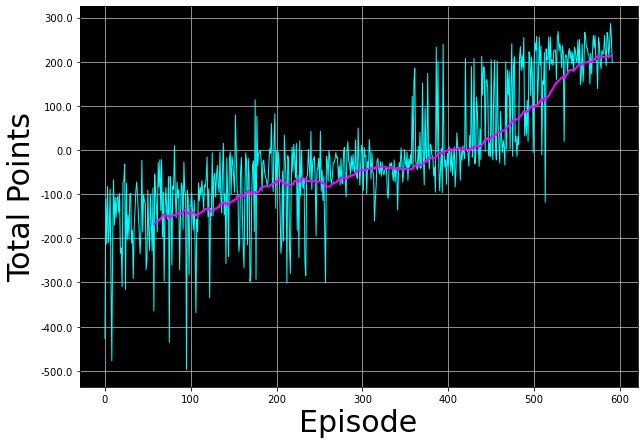

In [21]:
# Traza el historial de puntos totales junto con la media móvil.
utils.plot_history(total_point_history)

<a name="10"></a>
## 10 - Ver el agente entrenado en acción

Ahora que hemos entrenado a nuestro agente, podemos verlo en acción. Utilizaremos la función `utils.create_video` para crear un vídeo de nuestro agente interactuando con el entorno utilizando la red $Q$ entrenada. La función `utils.create_video` utiliza la librería `imageio` para crear el vídeo. Esta librería produce algunas advertencias que pueden distraer, por lo que, para suprimir estas advertencias ejecutamos el código siguiente.

In [22]:
# Suppress warnings from imageio.
import logging
logging.getLogger().setLevel(logging.ERROR)

En la celda de abajo creamos un vídeo de nuestro agente interactuando con el entorno del Lunar Lander usando la red entrenada `q_network`. El vídeo se guarda en la carpeta `videos` con el nombre de archivo dado. Usamos la función `utils.embed_mp4` para incrustar el vídeo en el Jupyter Notebook y así poder verlo aquí directamente sin tener que descargarlo.

Debemos tener en cuenta que como el módulo de aterrizaje lunar comienza con una fuerza inicial aleatoria aplicada a su centro de masa, cada vez que se ejecute la celda de abajo se verá un vídeo diferente. Si el agente fue entrenado correctamente, debería ser capaz de aterrizar el módulo de aterrizaje en la plataforma de aterrizaje cada vez, independientemente de la fuerza inicial aplicada a su centro de masa.

In [23]:
filename = "./videos/lunar_lander.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

<a name="11"></a>
## 11 - ¡Enhorabuena!

Has utilizado con éxito Deep Q-Learning con Experience Replay para entrenar a un agente a aterrizar un módulo de aterrizaje lunar de forma segura en una plataforma de aterrizaje en la superficie de la luna. ¡Enhorabuena!

<a name="12"></a>
## 12 - References

If you would like to learn more about Deep Q-Learning, we recommend you check out the following papers.


* Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).


* Lillicrap, T. P., Hunt, J. J., Pritzel, A., et al. Continuous Control with Deep Reinforcement Learning. ICLR (2016).


* Mnih, V., Kavukcuoglu, K., Silver, D. et al. Playing Atari with Deep Reinforcement Learning. arXiv e-prints.  arXiv:1312.5602 (2013).